## Setup

### Imports

In [1]:
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

from IPython import display

import stockcore.data as scdata
import stockcore.models as scmodels
import stockcore.environment as scenv
import stockcore.utils as scutils
from stocksense.api import data as api_data

In [2]:
is_ipython = scutils.setup_mpl()
device = scutils.get_device()

if is_ipython:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

### Data

In [3]:
stock_list = ['MSFT', 'AAPL', 'AXP', 'AMGN', 'CSCO', 'HON', 'IBM', 'KO']

dfs_train = [await api_data.get_kline_df('yfinance', i, datetime(2000, 1, 1), datetime(2022, 12, 31), '1d') for i in stock_list]
assert all([i.shape == dfs_train[0].shape for i in dfs_train])

dfs_test = [await api_data.get_kline_df('yfinance', i, datetime(2023, 1, 1), datetime(2024, 12, 1), '1d') for i in stock_list]
assert all([i.shape == dfs_test[0].shape for i in dfs_test])

df_dji = await api_data.get_kline_df('yfinance', '^DJI', datetime(2023, 1, 1), datetime(2024, 12, 1), '1d')

### Environment

In [4]:
env_kwargs = {
    'trading_fees': 0.01/100,
    'windows': 5
}
env = scenv.MultiStockTradingEnv(name= "MY_ENV", dfs=dfs_train, **env_kwargs)
env_for_buy_and_hold = scenv.MultiStockTradingEnv(name= "MY_ENV_FOR_BUY_AND_HOLD", dfs=dfs_test, strategy='buy_and_hold', **env_kwargs)
env_for_dji = scenv.MultiStockTradingEnv(name= "MY_ENV_FOR_DJI", dfs=[df_dji], strategy='buy_and_hold', **env_kwargs)
env_test = scenv.MultiStockTradingEnv(name= "MY_ENV_TEST", dfs=dfs_test, **env_kwargs)

## Baseline: Random Agent

In [5]:
done, truncated = False, False
observation, info = env_test.reset()
while not done and not truncated:
    action = env_test.action_space.sample()
    observation, reward, done, truncated, info = env_test.step(action)
history_random = env_test.get_history()

Portfolio Return : 10.52%


## Baseline: Buy and Hold

In [6]:
done, truncated = False, False
observation, info = env_for_buy_and_hold.reset()
while not done and not truncated:
    action = [0] * (len(stock_list)+1)
    action[1] = 1
    observation, reward, done, truncated, info = env_for_buy_and_hold.step(action)
history_buy_and_hold = env_for_buy_and_hold.get_history()
print(history_buy_and_hold[0], history_buy_and_hold[-1])

Portfolio Return : 33.18%
1000.0 1331.8345413936418


## Baseline: DJI

In [7]:
done, truncated = False, False
observation, info = env_for_dji.reset()
while not done and not truncated:
    action = [1, 0]
    observation, reward, done, truncated, info = env_for_dji.step(action)
history_dji = env_for_dji.get_history()

Portfolio Return : 29.87%


## Agent: DQN

### Build Agent

In [8]:
policy_kwargs = {
    'net_arch': [128, 128]
}
hparas = {
    'batch_size': 128,
    'gamma': 0.99,
    'exploration_initial_eps': 0.9,
    'exploration_final_eps': 0.05,
    'exploration_fraction': 0.001,
    'target_update_interval': 10000,
    'learning_rate': 1e-4,
    'buffer_size': 10000,
    'policy_kwargs': policy_kwargs,
    # 'tensorboard_log': 'dqn_tensorboard'
}

In [9]:
from stable_baselines3 import DQN

model = DQN('MlpPolicy', env, **hparas).learn(total_timesteps=env.get_dfs_length() * 15)
model.save("dqn")

model = DQN.load("dqn")

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env_test.step(action)
history_dqn = env_test.get_history()

Portfolio Return : 104.04%
Portfolio Return : 4477.99%
Portfolio Return : 87792.10%
Portfolio Return : 11611.57%
Portfolio Return : 161291.48%
Portfolio Return : 799640.39%
Portfolio Return : 412630.56%
Portfolio Return : 285032.24%
Portfolio Return : 2150149.60%
Portfolio Return : 668763.38%
Portfolio Return : 1708330.33%
Portfolio Return : 6278419.18%
Portfolio Return : 11779710.33%
Portfolio Return : 137818642.03%
Portfolio Return : 16239583.71%
predicting...
Portfolio Return : 30.89%


## Agent: A2C

In [10]:
from stable_baselines3 import A2C

model = A2C('MlpPolicy', env, device='cpu').learn(total_timesteps=env.get_dfs_length() * 15)
model.save("a2c")

model = A2C.load("a2c", device='cpu')

print("predicting...")
done, truncated = False, False
obs, info = env_test.reset()
while not done and not truncated:
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env_test.step(action)
history_a2c = env_test.get_history()

Portfolio Return : -12.65%
Portfolio Return : 735.97%
Portfolio Return : 371.88%
Portfolio Return : 6196.97%
Portfolio Return : 26.50%
Portfolio Return : -9.87%
Portfolio Return : 121.75%
Portfolio Return : 89.08%
Portfolio Return : 59.42%
Portfolio Return :  7.98%
Portfolio Return : -67.97%
Portfolio Return : 70.61%
Portfolio Return : 6816.71%
Portfolio Return : 45201.51%
Portfolio Return : 11645.49%
predicting...
Portfolio Return : 33.18%


### Visualization

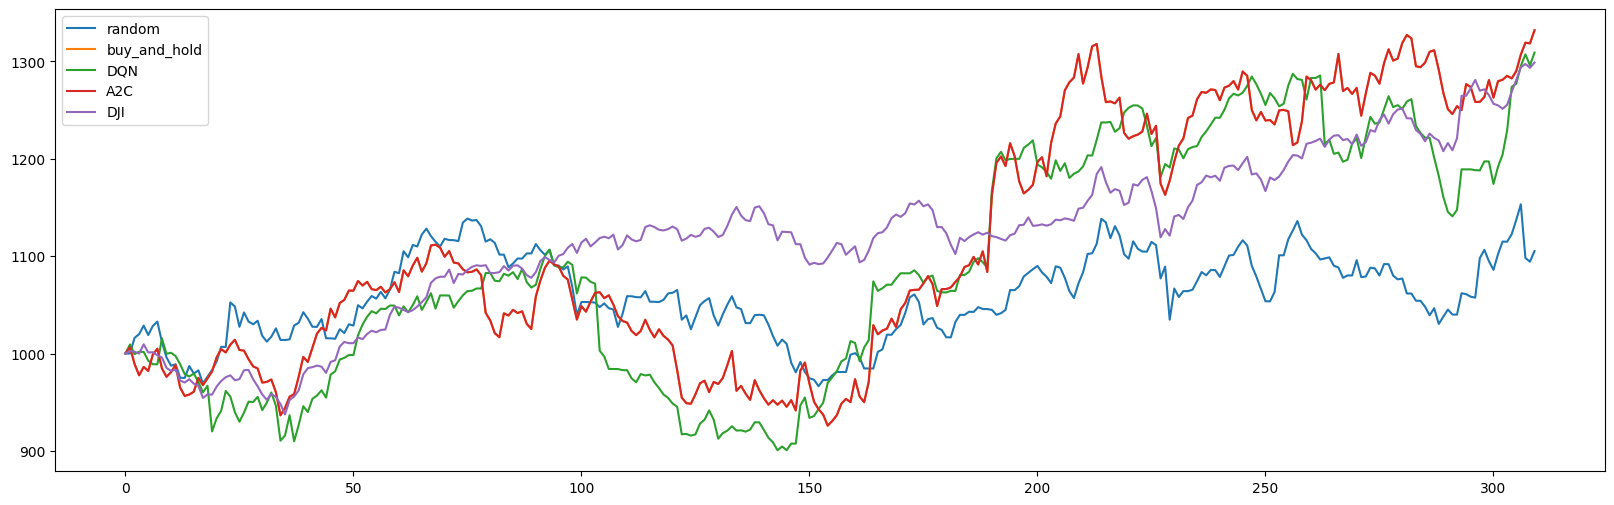

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(history_random, label="random")
plt.plot(history_buy_and_hold, label="buy_and_hold")
plt.plot(history_dqn, label="DQN")
plt.plot(history_a2c, label="A2C")
plt.plot(history_dji, label="DJI")
plt.legend()
plt.show()

In [12]:
df_solution = pd.DataFrame()
df_solution['unix'] = env_test.get_date()[4:]
df_solution['account_value_dqn'] = history_dqn
df_solution['daily_return_dqn'] = df_solution['account_value_dqn'].pct_change(1)
df_solution['account_value_a2c'] = history_a2c
df_solution['daily_return_a2c'] = df_solution['account_value_a2c'].pct_change(1)
print(df_solution.head(5))

                                    unix  account_value_dqn  daily_return_dqn  \
date                                                                            
2023-09-08 00:00:00+00:00  1694131200000        1000.000000               NaN   
2023-09-11 00:00:00+00:00  1694390400000        1009.328154          0.009328   
2023-09-12 00:00:00+00:00  1694476800000         999.385692         -0.009851   
2023-09-13 00:00:00+00:00  1694563200000        1001.785578          0.002401   
2023-09-14 00:00:00+00:00  1694649600000        1001.685400         -0.000100   

                           account_value_a2c  daily_return_a2c  
date                                                            
2023-09-08 00:00:00+00:00        1000.000000               NaN  
2023-09-11 00:00:00+00:00        1006.521899          0.006522  
2023-09-12 00:00:00+00:00         989.349985         -0.017061  
2023-09-13 00:00:00+00:00         977.621466         -0.011855  
2023-09-14 00:00:00+00:00         986.2074